In [1]:
# OpenCV, numpy, matplotlib etc. 
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation
import os, sys

# Local files
sys.path.insert(0,'../')
import pyClient
from pyClient import Environment
import utils

### Environment

Connect to the unity hallway environment.

#### Attention: Start Unity server first!

In [2]:
# Unity environment
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to
port       = 13000       # Port number that the TCP/IP interface listens to
size       = 128
screen_height = screen_width = size

environment = pyClient.Environment(ip = ip, port = port, size = size, channels=16)

print(environment.client)

<socket.socket fd=1848, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 49692), raddr=('127.0.0.1', 13000)>


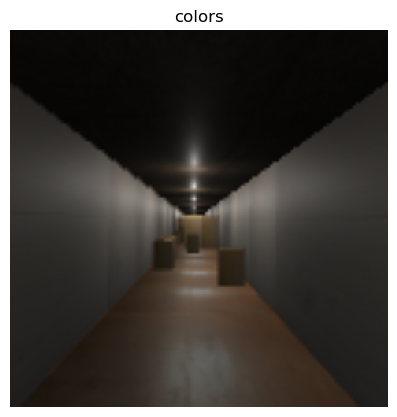

In [3]:
## After connecting, the first thing you should do is 
## resetting the environment 

ENV_TYPE = 0 # 0: plain 1: complex 2: plain_test 3: complex_test

# Reset environment
end, reward, state_raw = environment.reset(ENV_TYPE)
state = environment.state2arrays(state_raw)


## Visualize the environment state 
KIND = 'colors' # Try  'colors', 'objseg', 'semseg',
                #      'normals', 'flow' or 'depth'

# display current state (128x128 image)
img = state[KIND]
img = cv2.resize(img, (480,480))

plt.figure(figsize=(5,5),dpi=100)
plt.imshow(img)
plt.title(KIND)
plt.axis('off')
plt.show()


In [4]:
# For reproducability you can reset the
# random number generator with a specific seed
SEED = 99 # range 0-255
_, _, _= environment.setRandomSeed(SEED)
end, reward, state_raw = environment.reset(1)

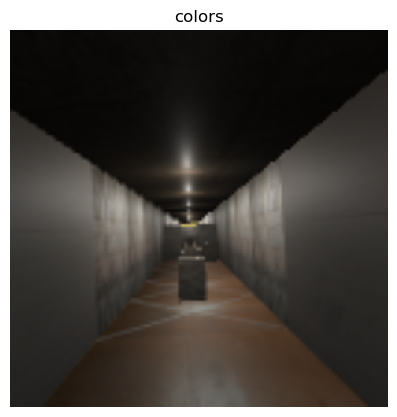

Agent obtained reward: 10 and end signal: 0


In [5]:
### Try walking around with the agent
STEP_TYPE = 0 # 0: forward, 1: left, 2: right

# Reset environment
end, reward, state_raw = environment.step(STEP_TYPE)
state = environment.state2arrays(state_raw)

## Visualize
KIND = 'colors'

# display current state (128x128 image)
img = state[KIND]
img = cv2.resize(img, (480,480))

plt.figure(figsize=(5,5),dpi=100)
plt.imshow(img)
plt.title(KIND)
plt.axis('off')
plt.show()

## End signal (0: nothing happened, 1: box collision, 2: wall collision, 3: step target reached)
print('Agent obtained reward: {} and end signal: {}'.format(reward, end))

In [6]:
### Animated stepping

# import matplotlib
# %matplotlib notebook

# f = plt.figure()
# ax = f.gca()

# im = environment.state2usableArray(state_raw)
# image = plt.imshow(im, interpolation='None', animated=True)
# plt.axis('off')

# def animateSteps(frame_index):
#     # Take a step 0:forward 1:left 2:right
#     command = np.random.randint(3)
#     end, reward, state_raw = environment.step(command)
#     reward = -reward + 100 if reward > 100 else reward
#     img = environment.state2arrays(state_raw)[KIND]
    
#     # update frame
#     image.set_data(im)
#     ax.set_title('Reward: {}'.format(reward))
#     return image,

# ani = matplotlib.animation.FuncAnimation(f, animateSteps, interval=500, frames=10, blit=True)

## Phosphene Simulator

In [7]:
# RESOLUTION    = (50,50) # Number of phosphenes
# JITTER        = 0.35    # Variation in phosphene location (w.r.t. rectangular grid)
# INTENSITY_VAR = 0.9     # Variation in phosphene intensity
# SIGMA         = 0.9     # Size parameter for the individual phosphenes 

# phosphene_simulator = utils.PhospheneSimulator(phosphene_resolution=RESOLUTION,
#                                                jitter=JITTER,
#                                                intensity_var=INTENSITY_VAR,
#                                                sigma=SIGMA)

# # State (128x128 img)
# img = environment.state2arrays(state_raw)[KIND]
# img = cv2.resize(img, (480,480))

# # Activation masks
# grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# binarized = (255*(grayscale>100)).astype('uint8')
# contours  = cv2.Canny(img, 35,70)

# # Visualize
# plt.figure(figsize=(15,5),dpi=150)

# plt.subplot(1,3,1)
# phos = phosphene_simulator(grayscale)
# plt.imshow(phos, cmap='gray')
# plt.axis('off')

# plt.subplot(1,3,2)
# phos = phosphene_simulator(binarized)
# plt.imshow(phos, cmap='gray')
# plt.axis('off')

# plt.subplot(1,3,3)
# phos = phosphene_simulator(contours)
# plt.imshow(phos, cmap='gray')
# plt.axis('off')


# plt.show()

In [8]:
# Visualize
# plt.figure(figsize=(15,5),dpi=150)

# plt.subplot(1,3,1)
# plt.imshow(grayscale, cmap='gray')
# plt.axis('off')

# plt.subplot(1,3,2)
# plt.imshow(binarized, cmap='gray')
# plt.axis('off')

# plt.subplot(1,3,3)
# plt.imshow(contours, cmap='gray')
# plt.axis('off')


# plt.show()

In [9]:
## Phosphene Simulator (Laura Version)

#local file where simulator is located
import sim_utils
import math

## STEP 1: Phosphene map generation parameters: Generates a list of polar coordinates representing the relative positioning of each phosphene.
#This step  can be skipped if a custom list of coordinates is provided instead.

#phosphene map is expessed as a map of polar angles and eccentricities.
ecc_coverage   = 30                # in degrees
polar_coverage =  2 * math.pi      # in radians

#number of phosphenes placed at each polar angle.
phosphenes_per_polar = 25
phosphenes_per_ecc   = 70

noise_scale = 0.14 #standard deviation of the random noise added to phosphene position

windowSize = 480

## STEP 2: Establishing of phosphene simulator
COEFF = 60 # coefficient used to ajust calculated phosphene size to display pixel size - ajust for optimal display
eff_activation = 1  #diameter of the area in which neurons are activated - in theory this is in mm
                    #(but it is unclear if mm is accurate-relative changes to area should work as intended) 


phosphene_simulator = sim_utils.PhospheneSimulator(ecc_coverage, 
                                                   polar_coverage, 
                                                   phosphenes_per_polar, 
                                                   phosphenes_per_ecc, 
                                                   noise_scale, 
                                                   coeff = COEFF, 
                                                   eff_activation = eff_activation,
                                                   windowSize = windowSize)

In [10]:
## STEP 3: create a memory trace.
# When using the simulator multiple times in a row, to generate multiple frames, the memory trace will be updated
# - to contain information about previous frames.

#Memory trace parameters
theta = 0 #Lower bound; represents something like a minimal electrode current to elicit phosphene
decay = 0.9 #decay rate of memory
decay_activation = 0.05 #decay of activation
input_effect = 0.75 #effect of new input on image
trace_increase = 0.4 #effect of new input on memory trace
total_phosphenes = getattr(phosphene_simulator, 'phosphenes')
n_phosphenes = len(total_phosphenes) #number of phosphenes

#Establish Memory Trace
memory_trace = sim_utils.Memory(theta, decay, decay_activation, input_effect, trace_increase, n_phosphenes)


In [11]:
## STEP 4: Generate masks, then give a mask and the memory trace to the phosphene simulator.

# State (128x128 img) -> is this actually a 480 img?
img = environment.state2arrays(state_raw)[KIND]
img = cv2.resize(img, (windowSize,windowSize))

# Activation masks
grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binarized = (255*(grayscale>100)).astype('uint8')
contours  = cv2.Canny(img, 35,70)

# Generates phosphene image and updated memory trace.
# As this demo only handles a single image, memory trace is not used- but for a sequence, simply pass the memory trace to the next frame.
phos, memory_trace = phosphene_simulator(contours, memory_trace)

memory trace rows
2
memory trace columns
1750


..\sim_utils.py:148: RuntimeWarning: invalid value encountered in true_divide
  I = np.sum(image_filtered[y-halfs:y+halfs, x-halfs:x+halfs]) / np.power(s,2) #current used for simulation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 479.5, 479.5, -0.5)

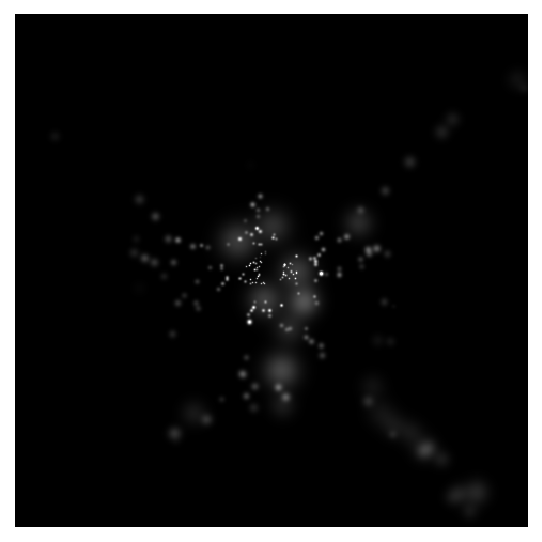

In [12]:

# Visualize
plt.figure(figsize=(15,5),dpi=150)

plt.subplot(1,3,1)
plt.imshow(phos, cmap='gray')
plt.axis('off')

memory trace rows
3
memory trace columns
1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


memory trace rows
4
memory trace columns
1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


memory trace rows
5
memory trace columns
1750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 479.5, 479.5, -0.5)

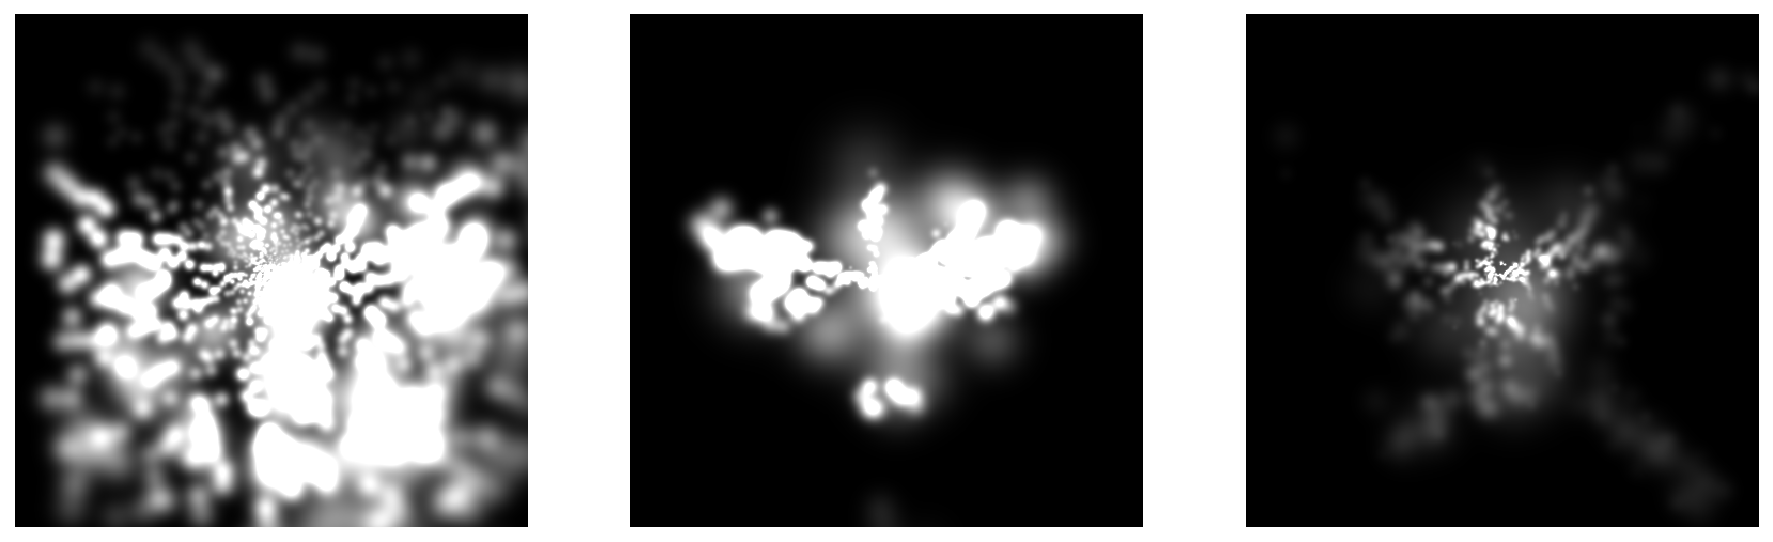

In [13]:
# Visualize
plt.figure(figsize=(15,5),dpi=150)

plt.subplot(1,3,1)
phos, memory_trace = phosphene_simulator(grayscale, memory_trace)
plt.imshow(phos, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
phos, memory_trace = phosphene_simulator(binarized, memory_trace)
plt.imshow(phos, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
phos, memory_trace = phosphene_simulator(contours, memory_trace)
plt.imshow(phos, cmap='gray')
plt.axis('off')